# Frequency Calculations

In [1]:
import numpy as np

In [2]:
with open('qm_files/drop_0375_0qm_256mm.out') as f:
    contents_qmoutput = f.read()

## Advanced: calculate frequencies directly from the mass-weighted Hessian

How can you prove to yourself that the frequencies printed at the end of a QM output are correct? We can take the Hessian (mass-weighted or otherwise), which is the second derivative of the energy with respect to nuclear displacements,

$H_{ij} = \frac{\partial^{2} E}{\partial x_{i} \partial x_{j}}$,

diagonalize it, and multiply the eigenvalues by some constants to obtain vibrational (normal mode) frequencies in wavenumbers.

A useful resource for understanding this is given by http://sirius.chem.vt.edu/wiki/doku.php?id=crawdad:programming:project2, which most of this section is derived from.

First, we need to locate the Hessian. If we can only find one that isn't mass-weighted, we'll need to do that too.

In [3]:
contents_splitlines = contents_qmoutput.splitlines()

In [4]:
contents_splitlines[8500:8600]

[' CPU 0.00 s  wall 0.00 s',
 ' CPU 2.38 s  wall 2.38 s',
 '',
 ' Total DFTman time = 2.38 CPUs 2.38 Wall',
 '   1         0          12      0.175973    0.044861',
 ' CPU 0.00 s  wall 0.00 s',
 ' CPU 2.38 s  wall 2.38 s',
 '',
 ' Total DFTman time = 2.38 CPUs 2.38 Wall',
 '   2         0          12      0.013238    0.002872',
 ' CPU 0.00 s  wall 0.00 s',
 ' CPU 2.38 s  wall 2.38 s',
 '',
 ' Total DFTman time = 2.38 CPUs 2.38 Wall',
 '   3         0          12      0.000766    0.000161',
 ' CPU 0.00 s  wall 0.00 s',
 ' CPU 2.38 s  wall 2.38 s',
 '',
 ' Total DFTman time = 2.38 CPUs 2.38 Wall',
 '   4         2          10      0.000037    0.000009',
 ' CPU 0.00 s  wall 0.00 s',
 ' CPU 2.05 s  wall 2.05 s',
 '',
 ' Total DFTman time = 2.05 CPUs 2.05 Wall',
 '   5        12           0      0.000000    0.000000    Roots Converged',
 ' CPU 0.00 s  wall 0.00 s',
 ' CPU 2.38 s  wall 2.38 s',
 '',
 ' Total DFTman time = 2.38 CPUs 2.38 Wall',
 ' Calculating analytic Hessian of the SCF energ

There's a line `Hessian of the SCF Energy`, which sounds like it might not be mass-weighted. First, let's try and extract it.

In [5]:
# lists are iterable, but not `iterators` themselves.
contents_iter = iter(contents_splitlines)
for line in contents_iter:
    if 'Hessian of the SCF Energy' in line:
        while 'Gradient time:' not in line:
            print(line)
            line = next(contents_iter)

 Hessian of the SCF Energy
            1           2           3           4           5           6
    1   1.0320326  -0.8205741  -0.5265428  -0.5771301   0.4113205   0.2760194
    2  -0.8205741   0.8663686   0.4766125   0.4156759  -0.4013503  -0.2245970
    3  -0.5265428   0.4766125   0.4339413   0.2675925  -0.2138938  -0.2126253
    4  -0.5771301   0.4156759   0.2675925   0.5964568  -0.4604293  -0.3031803
    5   0.4113205  -0.4013503  -0.2138938  -0.4604293   0.4124842   0.2481263
    6   0.2760194  -0.2245970  -0.2126253  -0.3031803   0.2481263   0.1960277
    7  -0.4490074   0.3972323   0.2570313  -0.0216492   0.0515882   0.0276341
    8   0.4049835  -0.4666738  -0.2637577   0.0470072  -0.0102116  -0.0231149
    9   0.2481858  -0.2510492  -0.2186790   0.0377319  -0.0348896   0.0165142
            7           8           9
    1  -0.4490074   0.4049835   0.2481858
    2   0.3972323  -0.4666738  -0.2510492
    3   0.2570313  -0.2637577  -0.2186790
    4  -0.0216492   0.0470072   0

The Hessian matrix should have $3N * 3N$ elements, where $N$ is the number of atoms; this is because each atom contributes 3 Cartesian coordinates, and it is two-dimensional because of the double derivative. By this logic, the gradient may be represented by a length $3N$ vector, and cubic force constants by an array of shape $[3N, 3N, 3N]$.

Now that we can extract only the lines that contain the Hessian information, let's make a NumPy array that will hold the final results.

In [6]:
N = 3
hessian_scf = np.zeros(shape=(3*N, 3*N))

Here comes the tricky Python bits. For matrices, Q-Chem prints a maximum of 6 columns per block; this info is necessary for keeping track of where we are during parsing.

In [7]:
ncols_block = 6

Here's the machinery that will do the actual iteration over the matrix, leaving out the part where the results are stored.

In [8]:
contents_iter = iter(contents_splitlines)

for line in contents_iter:
    if 'Hessian of the SCF Energy' in line:
        # skip the line containing the header
        line = next(contents_iter)
        
        # keep track of how many "columns" there are left; better than searching
        # for the gradient line
        ncols_remaining = 3*N
        while ncols_remaining > 0:
            # this must be the column header
            if len(line.split()) == min(ncols_block, ncols_remaining):
                print(line)
                ncols_remaining -= ncols_block
                sline = line.split()
                colmin, colmax = int(sline[0]) - 1, int(sline[-1])
                line = next(contents_iter)
            # iterate over the rows
            for row in range(3*N):
                print(line)
                line = next(contents_iter)

            1           2           3           4           5           6
    1   1.0320326  -0.8205741  -0.5265428  -0.5771301   0.4113205   0.2760194
    2  -0.8205741   0.8663686   0.4766125   0.4156759  -0.4013503  -0.2245970
    3  -0.5265428   0.4766125   0.4339413   0.2675925  -0.2138938  -0.2126253
    4  -0.5771301   0.4156759   0.2675925   0.5964568  -0.4604293  -0.3031803
    5   0.4113205  -0.4013503  -0.2138938  -0.4604293   0.4124842   0.2481263
    6   0.2760194  -0.2245970  -0.2126253  -0.3031803   0.2481263   0.1960277
    7  -0.4490074   0.3972323   0.2570313  -0.0216492   0.0515882   0.0276341
    8   0.4049835  -0.4666738  -0.2637577   0.0470072  -0.0102116  -0.0231149
    9   0.2481858  -0.2510492  -0.2186790   0.0377319  -0.0348896   0.0165142
            7           8           9
    1  -0.4490074   0.4049835   0.2481858
    2   0.3972323  -0.4666738  -0.2510492
    3   0.2570313  -0.2637577  -0.2186790
    4  -0.0216492   0.0470072   0.0377319
    5   0.0515882 

An important note: the Hessian (and all other matrices in the output) start from 1, but Python indices for lists and arrays start at 0; this is why `int() - 1` shows up. But why not for `colmax`? Because of how Python slicing for lists and arrays doesn't include the ending number. (Elaborate?)

In [9]:
contents_iter = iter(contents_splitlines)

for line in contents_iter:
    if 'Hessian of the SCF Energy' in line:
        # skip the line containing the header
        line = next(contents_iter)
        
        # keep track of how many "columns" there are left; better than searching
        # for the gradient line
        ncols_remaining = 3*N
        while ncols_remaining > 0:
            # this must be the column header
            if len(line.split()) == min(ncols_block, ncols_remaining):
                ncols_remaining -= ncols_block
                sline = line.split()
                colmin, colmax = int(sline[0]) - 1, int(sline[-1])
                line = next(contents_iter)
            # iterate over the rows
            for row in range(3*N):
                sline = line.split()
                rowidx = int(sline[0]) - 1
                hessian_scf[rowidx, colmin:colmax] = list(map(float, sline[1:]))
                line = next(contents_iter)

In [10]:
hessian_scf

array([[ 1.0320326, -0.8205741, -0.5265428, -0.5771301,  0.4113205,
         0.2760194, -0.4490074,  0.4049835,  0.2481858],
       [-0.8205741,  0.8663686,  0.4766125,  0.4156759, -0.4013503,
        -0.224597 ,  0.3972323, -0.4666738, -0.2510492],
       [-0.5265428,  0.4766125,  0.4339413,  0.2675925, -0.2138938,
        -0.2126253,  0.2570313, -0.2637577, -0.218679 ],
       [-0.5771301,  0.4156759,  0.2675925,  0.5964568, -0.4604293,
        -0.3031803, -0.0216492,  0.0470072,  0.0377319],
       [ 0.4113205, -0.4013503, -0.2138938, -0.4604293,  0.4124842,
         0.2481263,  0.0515882, -0.0102116, -0.0348896],
       [ 0.2760194, -0.224597 , -0.2126253, -0.3031803,  0.2481263,
         0.1960277,  0.0276341, -0.0231149,  0.0165142],
       [-0.4490074,  0.3972323,  0.2570313, -0.0216492,  0.0515882,
         0.0276341,  0.4682529, -0.4483464, -0.2827598],
       [ 0.4049835, -0.4666738, -0.2637577,  0.0470072, -0.0102116,
        -0.0231149, -0.4483464,  0.4758137,  0.2854735],


The SCF Hessian has successfully been parsed from the output file and stored in a NumPy array. Since it needs to be mass-weighted, we need the masses of each atom. They're printed at the very end of the output file, and extracting them should be easier than for the Hessian.

In [11]:
contents_iter = iter(contents_splitlines)

for line in contents_iter:
    if 'Zero point vibrational energy:' in line:
        line = next(contents_iter)
        line = next(contents_iter)
        while 'Molecular Mass:' not in line:
            print(line.split())
            line = next(contents_iter)

['Atom', '1', 'Element', 'C', 'Has', 'Mass', '12.00000']
['Atom', '2', 'Element', 'O', 'Has', 'Mass', '15.99491']
['Atom', '3', 'Element', 'O', 'Has', 'Mass', '15.99491']


In [12]:
masses = []

contents_iter = iter(contents_splitlines)

for line in contents_iter:
    if 'Zero point vibrational energy:' in line:
        line = next(contents_iter)
        line = next(contents_iter)
        while 'Molecular Mass:' not in line:
            masses.append(float(line.split()[-1]))
            line = next(contents_iter)

In [13]:
masses

[12.0, 15.99491, 15.99491]

Hopefully alarm bells are going off in your head right about now. **Units!** What units are we working in? Units units units!

The masses above are in amu (https://en.wikipedia.org/wiki/Atomic_mass_unit).

The SCF Hessian is certainly in atomic units (https://en.wikipedia.org/wiki/Atomic_units). Internally, all quantum chemistry programs work in atomic units. From Wikipedia:

> This article deals with Hartree atomic units, where the numerical values of the following four fundamental physical constants are all unity by definition:

> * Electron mass $m_\text{e}$;
> * Elementary charge $e$;
> * Reduced Planck's constant $\hbar = h/(2 \pi)$;
> * Coulomb's constant $k_\text{e} = 1/(4 \pi \epsilon_0)$.

Since the Hessian is the double derivative of the energy with respect to nuclear diplacements (which can be considered positions or lengths), it will have units of $[\textrm{energy}][\textrm{length}]^{-2}$, which in atomic units is $E_{\textrm{h}}/a_{0}^{2}$ (hartree per bohr squared).

Now to mass-weight the SCF Hessian. The ordering along each dimension of the matrix is first atom x-coord, first atom y-coord, first atom z-coord, second atom x-coord, and so on. This means that every three columns or rows, we switch to a new atom. We'll be able to use integer division (`// 3`) to accomplish this cleanly.

In [14]:
# First, make a copy of the original Hessian array so we don't modify that one.
hessian_mass_weighted = hessian_scf.copy()

# We know the dimension a priori to be 3*N, but what if we don't? Use an array attribute!
shape = hessian_mass_weighted.shape
# shape is a tuple, here we "unpack" it.
nrows, ncols = shape

In [15]:
import math

In [16]:
for i in range(nrows):
    for j in range(ncols):
        _denom = math.sqrt(masses[i // 3] * masses[j // 3])
        hessian_mass_weighted[i, j] /= _denom

In [17]:
hessian_mass_weighted

array([[ 0.08600272, -0.06838118, -0.04387857, -0.0416574 ,  0.02968922,
         0.01992315, -0.03240947,  0.02923182,  0.01791412],
       [-0.06838118,  0.07219738,  0.03971771,  0.0300036 , -0.02896957,
        -0.01621147,  0.02867233, -0.03368464, -0.0181208 ],
       [-0.04387857,  0.03971771,  0.03616178,  0.0193149 , -0.01543891,
        -0.01534735,  0.01855259, -0.0190381 , -0.01578431],
       [-0.0416574 ,  0.0300036 ,  0.0193149 ,  0.03729041, -0.02878599,
        -0.0189548 , -0.00135351,  0.00293888,  0.00235899],
       [ 0.02968922, -0.02896957, -0.01543891, -0.02878599,  0.02578847,
         0.01551283,  0.00322529, -0.00063843, -0.00218129],
       [ 0.01992315, -0.01621147, -0.01534735, -0.0189548 ,  0.01551283,
         0.01225563,  0.00172768, -0.00144514,  0.00103247],
       [-0.03240947,  0.02867233,  0.01855259, -0.00135351,  0.00322529,
         0.00172768,  0.02927512, -0.02803057, -0.01767811],
       [ 0.02923182, -0.03368464, -0.0190381 ,  0.00293888, -0

We're ready to diagonalize the mass-weighted Hessian. If $\textrm{F}^{M}$ is the mass-weighted Hessian matrix, then the eigensystem defined by

$\textrm{F}^{M} \textbf{L} = \textbf{L} \Lambda$

results in the eigenvectors $\textbf{L}$, which are the **normal modes** of the system (the displacement vectors for each vibration, orthogonal to each other), and the eigenvalues $\Lambda$, which are the frequencies associated with each normal mode.

In [18]:
import scipy.linalg as spl

In [24]:
eigvals, eigvecs = spl.eig(hessian_mass_weighted)

The Hessian is Hermitian, so we could use `spl.eigh`, and not return any complex values, but they're useful for illustrating a point to be made later on.

The eigenvalues of the mass-weighted Hessian will have the same units as the mass-weighted Hessian itself, which are ($[\textrm{energy}][\textrm{length}]^{-2}[\textrm{mass}]^{-1}$), or $\frac{E_{\textrm{h}}}{a_{0}^{2}m_{\textrm{e}}}$. These need to be converted to wavenumbers.

I'll save everyone the trouble of doing this conversion; I've done it once and that was enough.

In [20]:
bohr2m = 0.529177249e-10
hartree2joule = 4.35974434e-18
speed_of_light = 299792458
avogadro = 6.0221413e+23

In [21]:
vib_constant = math.sqrt((avogadro*hartree2joule*1000)/(bohr2m*bohr2m))/(2*math.pi*speed_of_light*100)
vib_constant

5140.486777894163

The vibrational frequencies are related to the square roots of the eigenvalues, multiplied by the above constant:

$\omega_{i} = \textrm{constant} \times \sqrt{\lambda_{i}}$

In [29]:
vibfreqs = np.sqrt(eigvals) * vib_constant
vibfreqs

array([ 2508.10542052  +0.j        ,  1414.01700548  +0.j        ,
         606.19694253  +0.j        ,   618.38609054  +0.j        ,
           0.00000000+131.13466363j,     0.00000000 +95.09084298j,
          40.64456807  +0.j        ,     0.00000000 +36.54141755j,
           0.00000000 +30.66838975j])

Interesting! Some of our frequencies are imaginary, which NumPy handles properly (`math.sqrt(-1.0)` would throw an error). What does this mean?

The eigenvalues of the full molecular Hessian contain not just vibrational frequencies, but those corresponding to rotational and translational motion (though one would want to convert those to periods from frequencies). For non-linear molecules, this results in $3N-6$ vibrations, after subtracting out the 3 translations and 3 rotations. For linear molecules, this is $3N-5$.

Imaginary frequencies would normally mean we aren't at a stationary point on the potential energy surface (PES), but notice that these imaginary frequencies will be removed once we take into account translational and rotational motion. They could be zeroed out completely if one projects out translations and rotations from the Hessian, which we won't do for now.

In [36]:
vibfreqs_calculated = vibfreqs[:(3*N)-5].real
vibfreqs_calculated

array([ 2508.10542052,  1414.01700548,   606.19694253,   618.38609054])

How do the frequencies we've calculated compare with those printed in the output file?

In [44]:
vibfreqs_printed = np.array([2508.03, 1413.97, 605.67])

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

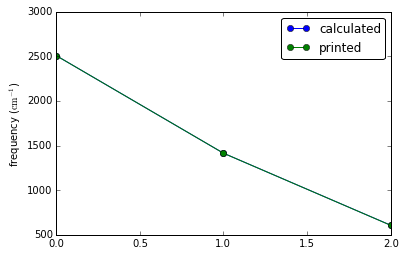

In [43]:
fig, ax = plt.subplots()

xticks = range(len(vibfreqs_printed))

ax.plot(xticks, vibfreqs_calculated[:-1], label='calculated', marker='o')
ax.plot(xticks, vibfreqs_printed, label='printed', marker='o')

ax.set_ylabel(r'frequency ($\mathrm{cm}^{-1}$)')

ax.legend(loc='best', fancybox=True)

The plot doesn't tell us very much, since the differences are all < 1 $\textrm{cm}^{-1}$:

In [45]:
vibfreqs_calculated[:-1] - vibfreqs_printed

array([ 0.07542052,  0.04700548,  0.52694253])

So far, so good; however, why would there be any discrepancies at all?

1. Numerical precision regarding constants used. The constants above might have more or fewer decimal places used than the QM package.
2. Numerical precision regarding the printed Hessian. The human-readable output is limited to 6 decimal places; machine-precision for doubles is ~1e-16.
3. Numerical precision regarding the atomic masses used. Ours didn't have many decimal places.
4. Contamination of the Hessian due to translations and rotations. Q-Chem projects these out of the Hessian before calculating the vibrational frequencies, but doesn't print this matrix unless `vibman_print` gets increased in the input file.

There is one more discrepancy. Notice that there are only 3 printed values, but 4 calculated values? Hmm...